In [1]:
%load_ext watermark

import numpy as np
import xarray as xr

import xskillscore as xs
import statsmodels.api as sm
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import cmocean.cm as cmo

%watermark -iv

numpy      : 1.24.4
sys        : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
scipy      : 1.11.3
matplotlib : 3.8.0
cmocean    : 3.0.3
xskillscore: 0.0.24
xarray     : 2023.10.1
cartopy    : 0.22.0
statsmodels: 0.14.0



In [2]:
%config InlineBackend.figure_formats = ['png']
mpl.rcParams['figure.dpi'] = 120

# False discovery rate

## References
Wilks, D. S. (2016). “The Stippling Shows Statistically Significant Grid Points”: How Research Results are Routinely Overstated and Overinterpreted, and What to Do about It. *Bulletin of the American Meteorological Society*, **97**(12), 2263–2273. https://doi.org/10.1175/BAMS-D-15-00267.1

Wilks, D. S. (2006). On “Field Significance” and the False Discovery Rate. *Journal of Applied Meteorology and Climatology*, **45**, 1181–1189. https://doi.org/10.1175/JAM2404.1

[False Discovery Rate - An Introduction to Statistical Learning](https://islp.readthedocs.io/en/main/labs/Ch13-multiple-lab.html#false-discovery-rate) &rarr; provides Python code for FDR implementation

[`scipy.stats.false_discovery_control` - SciPy function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.false_discovery_control.html) &rarr; almost exactly the same as my implementation below

# Load example data (CESM2 model output)

In [3]:
CESM_VARIABLE = [
    'LHFLX',
    'TREFHT',
]

INPATH = '/glade/work/bbuchovecky/PPE_analysis/time_averages'

tavg_cesm_ppe = {}
tavg_cesm_std = {}

print('CESM2 time average:')
for this_var in CESM_VARIABLE:
    print('\t'+this_var, end=' ')

    # Load ensemble members
    tavg_cesm_ppe[this_var] = xr.open_dataset(f'{INPATH}/COUP_PPE.cam.h0.time_mean.{this_var}.nc')[this_var]
    print(tavg_cesm_ppe[this_var].member.size, end='\n')
    
    # Load reference member
    tavg_cesm_std[this_var] = xr.open_dataset(f'{INPATH}/COUP_REF.cam.h0.time_mean.{this_var}.nc')[this_var]
        
    # Eliminate the degenerate dimension
    if ('member' in tavg_cesm_std[this_var].dims) and (tavg_cesm_std[this_var].member.size == 1):
        tavg_cesm_std[this_var] = tavg_cesm_std[this_var].isel(member=0)

CESM2 time average:
	LHFLX 36
	TREFHT 36


In [4]:
# Create new variables for data 

x = tavg_cesm_ppe['TREFHT'] - tavg_cesm_std['TREFHT']
y = tavg_cesm_ppe['LHFLX'] - tavg_cesm_std['LHFLX']

x_pt = (tavg_cesm_ppe['TREFHT'] - tavg_cesm_std['TREFHT']).isel(lat=10, lon=71)
y_pt = (tavg_cesm_ppe['LHFLX'] - tavg_cesm_std['LHFLX']).isel(lat=10, lon=71)

Text(0.5, 1.0, '[177.50, -71.05]')

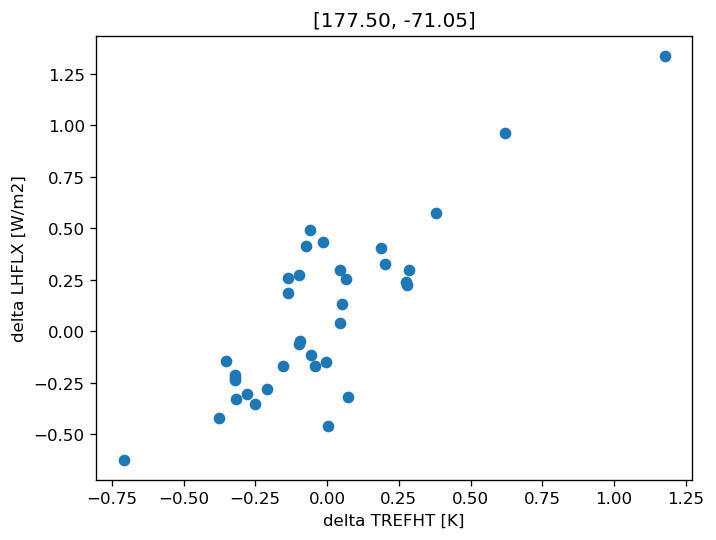

In [5]:
plt.scatter(x_pt, y_pt)
plt.xlabel('delta TREFHT [K]')
plt.ylabel('delta LHFLX [W/m2]')
plt.title(f'[{x_pt.lon.item():0.2f}, {x_pt.lat.item():0.2f}]')

# Calculate the FDR p-value

In [99]:
def calculate_linear_trend(x, y, dim, intercept=False):
    """
    Calculate a linear trend and create a Dataset with the slope and pvalues
    """
    def _linear_slope(x, y):
        m = stats.linregress(x, y)
        return xr.DataArray(m.slope)

    def _intercept(x, y):
        m = stats.linregress(x, y)
        return xr.DataArray(m.intercept)
    
    def _pvalue(x, y):
        m = stats.linregress(x, y)
        return xr.DataArray(m.pvalue)

    slope = xr.apply_ufunc(_linear_slope, x, y, vectorize=True, input_core_dims=[[dim], [dim]])
    pvalue = xr.apply_ufunc(_pvalue, x, y, vectorize=True, input_core_dims=[[dim], [dim]])

    trend_stats = xr.merge([
        slope.rename('linslope'),
        pvalue.rename('pvalue')
    ])

    if intercept:
        intercept = xr.apply_ufunc(_intercept, x, y, vectorize=True, input_core_dims=[[dim], [dim]])
        trend_stats = trend_stats.assign(intercept=intercept)

    return trend_stats


def calculate_pval_fdr(
    ps : xr.DataArray | np.ndarray,
    alpha_fdr : float) -> float:
    """
    Calculates the adjusted p-value threshold given a
    false discovery rate (FDR) control level.

    Wilks, D. S. (2016). “The Stippling Shows Statistically Significant Grid Points”:
    How Research Results are Routinely Overstated and Overinterpreted, and What to Do about It.
    Bulletin of the American Meteorological Society, 97(12), 2263–2273.
    https://doi.org/10.1175/BAMS-D-15-00267.1

    Parameters:
    -----------
    ps : xarray.DataArray | numpy.ndarray
        Array of p-values from local hypothesis tests at each grid point
    alpha_fdr : float
        The specified control level for the false discovery rate

    Returns:
    --------
    pval_fdr : float
        The adjusted p-value threshold
    """
    # Convert DataArray to NumPy array if necessary
    if isinstance(ps, xr.DataArray):
        ps = ps.values

    # Sort the p-values
    pval_sorted = np.sort(ps.flatten())
    n = pval_sorted.shape[0]

    # Select p-values below the FDR control level
    pval_sorted_subset = np.where(pval_sorted <= (np.linspace(1, n, n) / n) * alpha_fdr)[0]

    # Select the maximum p-value below the FDR control level as the FDR adjusted p-value
    if pval_sorted_subset.size > 0:
        pval_fdr = pval_sorted[pval_sorted_subset].max()
    else:
        print('no p-values above the FDR control level')
        pval_fdr = np.nan
    
    return pval_fdr

In [59]:
ds = calculate_linear_trend(x, y, 'member')

(0.0, 13824.0)

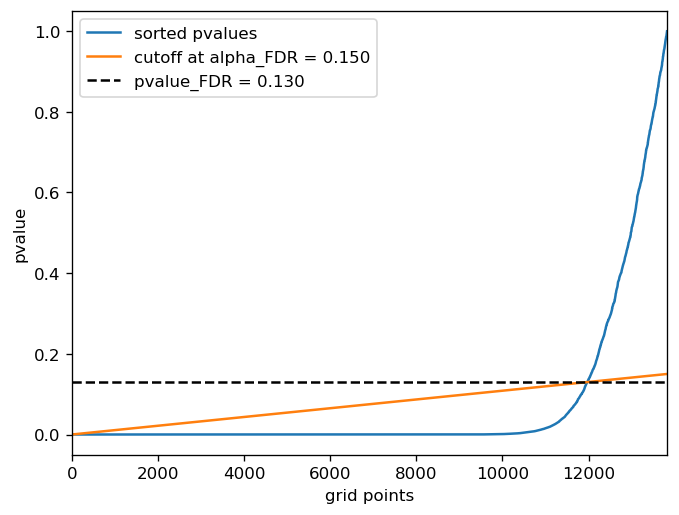

In [12]:
pval = ds['pvalue']
alpha_fdr = 0.15

# CALCULATE

pval_sorted = np.sort(pval.values.ravel())
n = pval_sorted.shape[0]
pval_sorted_subset = np.where(pval_sorted <= (np.linspace(1, n, n) / n) * alpha_fdr)[0]

if pval_sorted_subset.size > 0:
    pval_fdr = pval_sorted[pval_sorted_subset].max()
else:
    pval_fdr = np.nan

# PLOT
plt.plot(
    np.linspace(1, n, n),
    pval_sorted,
    label='sorted pvalues'
)

plt.plot(
    np.linspace(1, n, n),
    (np.linspace(1, n, n) / n) * alpha_fdr,
    label=f'cutoff at alpha_FDR ={alpha_fdr: 0.3f}'
)

plt.axhline(pval_fdr, 0, 1, ls='--', c='k', label=f'pvalue_FDR ={pval_fdr: 0.3f}')
plt.legend()
plt.xlabel('grid points')
plt.ylabel('pvalue')
plt.xlim(0, n)

# Create map of slope

In [53]:
def add_slope_pcolormesh(ax, x, y, vmin, vmax, cmap='PuOr', alpha_fdr=0.05, dim='member'):
    trend = calculate_linear_trend(x, y, dim)
    slope = trend['linslope']
    pvalue = trend['pvalue']

    pvalue_fdr = calculate_pval_fdr(pvalue, alpha_fdr)

    cf = slope.where(pvalue < pvalue_fdr).plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cmap, add_colorbar=False
    )

    my_cmap = mpl.colors.ListedColormap(['white', 'white'])
    slope.where(pvalue >= pvalue_fdr).plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=my_cmap, add_colorbar=False
    )

    return cf


def add_slope_contourf(ax, x, y, vmin, vmax, lev, cmap='PuOr', alpha_fdr=0.05, dim='member'):
    trend = calculate_linear_trend(x, y, dim)
    slope = trend['linslope']
    pvalue = trend['pvalue']

    pvalue_fdr = calculate_pval_fdr(pvalue, alpha_fdr)

    cyclic_slope, cyclic_lon = add_cyclic_point(slope, coord=slope.lon)

    cf = ax.contourf(
        cyclic_lon, lat, cyclic_slope, lev,
        cmap=cmap, vmin=vmin, vmax=vmax, extend='both',
        transform=ccrs.PlateCarree()
    )

    my_cmap = mpl.colors.ListedColormap(['white', 'white'])
    slope.where(pvalue >= pvalue_fdr).plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=my_cmap, add_colorbar=False
    )

    return cf

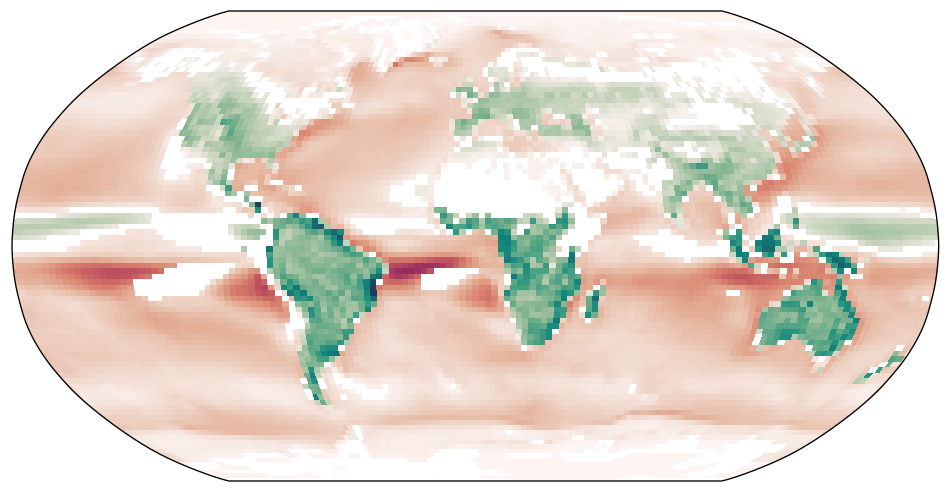

In [52]:
fig, ax = plt.subplots(
    figsize=(8, 4),
    layout='constrained',
    subplot_kw={'projection': ccrs.Robinson()}
)

add_slope_pcolormesh(ax, x, y, vmin, vmax, cmap=cmo.curl, alpha_fdr=0.05, dim='member')

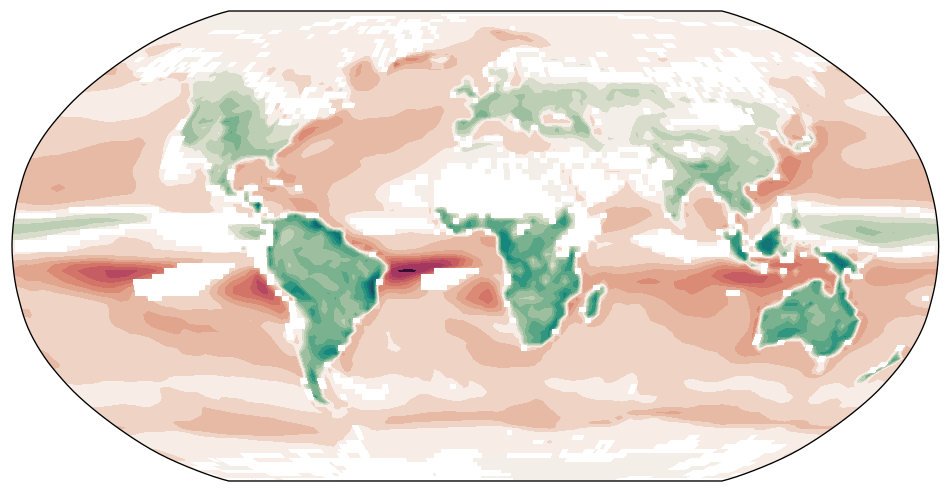

In [54]:
fig, ax = plt.subplots(
    figsize=(8, 4),
    layout='constrained',
    subplot_kw={'projection': ccrs.Robinson()}
)

add_slope_contourf(ax, x, y, vmin, vmax, 25, cmap=cmo.curl, alpha_fdr=0.05, dim='member')

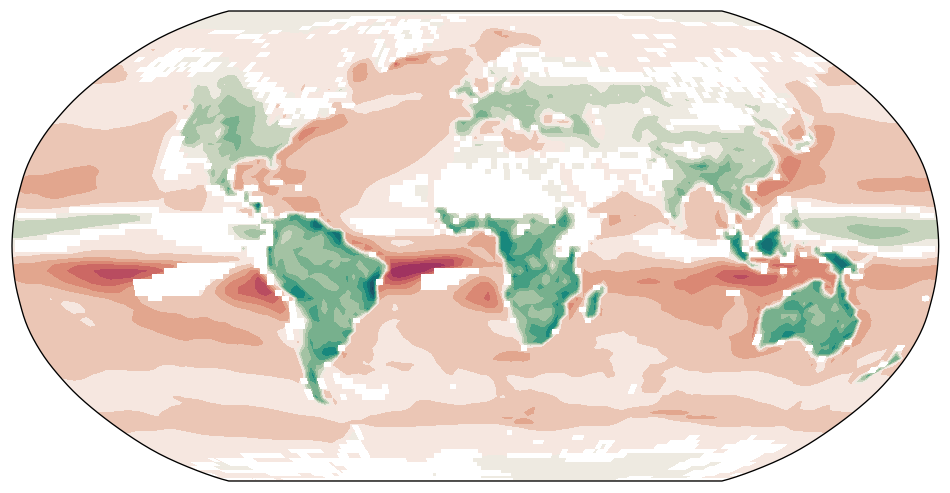

In [48]:
fig, ax = plt.subplots(
    figsize=(8, 4),
    layout='constrained',
    subplot_kw={'projection': ccrs.Robinson()}
)

# x = 
# y = 
alpha_fdr = 0.05
dim='member'

cmap = cmo.curl
vmin = -20
vmax = 20

trend = calculate_linear_trend(x, y, dim)
slope = trend['linslope']
pvalue = trend['pvalue']

lon = slope.lon
lat = slope.lat
cyclic_slope, cyclic_lon = add_cyclic_point(slope, coord=lon)

pvalue_fdr = calculate_pval_fdr(pvalue, alpha_fdr)

# cf = slope.where(pvalue < pvalue_fdr).plot.contourf(
#     ax=ax, transform=ccrs.PlateCarree(),
#     vmin=vmin, vmax=vmax, levels=25,
#     cmap=cmap, add_colorbar=False
# )

cf = ax.contourf(
    cyclic_lon, lat, cyclic_slope, lev,
    cmap=cmap, vmin=vmin, vmax=vmax, extend='both',
    transform=ccrs.PlateCarree()
)

my_cmap = mpl.colors.ListedColormap(['white', 'white'])
slope.where(pvalue >= pvalue_fdr).plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=my_cmap, add_colorbar=False
)

In [ ]:
# cf = axis.contourf(
#     cyclic_lon, lat, cyclic_slope, lev,
#     cmap=cmap, vmin=vmin, vmax=vmax, extend='both',
#     transform=ccrs.PlateCarree()
# )

# mpl.rcParams['hatch.linewidth'] = 0.1
# my_cmap = mpl.colors.ListedColormap(['lightgray', 'lightgray'])
# axis.contourf(
#     cyclic_lon, lat, masked_slope, [0, 1],
#     vmin=0, extend='neither',
#     hatches=['xxxxxxx', 'xxxxxxx'],
#     cmap=my_cmap,
#     alpha=1, transform=ccrs.PlateCarree()
# )

# axis.pcolormesh(
#     cyclic_lon, lat, masked_slope,
#     vmin=0,
#     hatch=['xxxxxxx', 'xxxxxxx'],
#     cmap=my_cmap,
#     alpha=1, transform=ccrs.PlateCarree()
# )

# Testing linear regression methods

In [ ]:
# xskillscore
slope_xs = xs.linslope(x_pt, y_pt).item()
slope_pval_xs = xs.pearson_r_p_value(x_pt, y_pt).item()

# statsmodel
x_pt_with_intercept = sm.add_constant(x_pt)
model_sm = sm.OLS(y_pt.values, x_pt_with_intercept)
results_sm = model_sm.fit()
intercept_sm, slope_sm = results_sm.params
slope_pval_sm = results_sm.pvalues[1]
yhat_sm = results_sm.predict(x_pt_with_intercept)

# scipy
results_sp = stats.linregress(x_pt, y_pt)
intercept_sp, slope_sp, slope_pval_sp = results_sp.intercept, results_sp.slope, results_sp.pvalue

print(f'xs: y = {slope_xs: 0.6f} * x +  b')
print(f'xs: pvalue={slope_pval_xs: 0.6e}')
print(f'sm: y = {slope_sm: 0.6f} * x + {intercept_sm: 0.6f}')
print(f'sm: pvalue={slope_pval_sm: 0.6e}')
print(f'sp: y = {slope_sp: 0.6f} * x + {intercept_sp: 0.6f}')
print(f'sp: pvalue={slope_pval_sp: 0.6e}')

xs: y =  1.059611 * x +  b
xs: pvalue= 1.107267e-10
sm: y =  1.059611 * x +  0.092839
sm: pvalue= 1.107267e-10
sp: y =  1.059611 * x +  0.092839
sp: pvalue= 1.107267e-10
